# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [2]:
rect_start = None
rect_end = None
drawing = False

In [3]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [4]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [ ]:
coord = interactive_bbox_selection("frames/frame_0000.png")

### Segment image based on rectangle coordinates

In [ ]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [5]:
def segmenting_image(coordinates, model, source, device="cpu"):
    results = model(source,
                    device=device,
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

100%|██████████| 38.8M/38.8M [00:00<00:00, 55.5MB/s]


Coordinates: [595, 187, 2461, 3081]

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\backgroundFunctions\images\IMG_20250506_193722.jpg: 640x640 1 0, 933.8ms
Speed: 25.1ms preprocess, 933.8ms inference, 216.3ms postprocess per image at shape (1, 3, 640, 640)


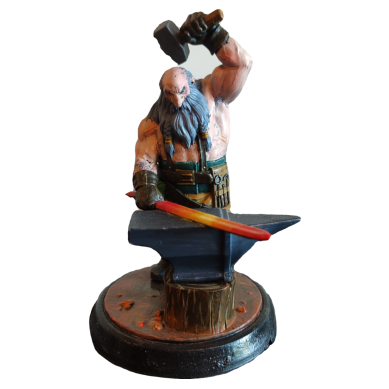

In [6]:
from ultralytics import SAM
%matplotlib inline
import torch

rect_start = None
rect_end = None
drawing = False

source = "images/IMG_20250506_193722.jpg"
model = SAM("models/mobile_sam.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source, device)

## 3D reconstruction from videos

### Extracting frames

In [1]:
import cv2
import os
from tqdm import tqdm
import numpy as np

def extract_frames(video_path, output_folder="frames", num_frames=10):
    """
    Extract a specified number of equally spaced frames from a video.

    Args:
        video_path (str): The path to the video to be extracted.
        output_folder (str): The path to save the extracted frames.
        num_frames (int): The number of equally spaced frames to extract.
    
    Returns:
        Extracted frames will be saved in the output_folder in png format.
    """

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))
    
    print("------ Extracting frames ------")

    # Calculate the frame indices to extract
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    extracted_count = 0
    with tqdm(total=num_frames, unit="frame") as pbar:
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                print(f"Warning: Unable to read frame at index {frame_idx}")
                continue

            if rotation == 90:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                frame = cv2.rotate(frame, cv2.ROTATE_180)
            elif rotation == 270:
                frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1
            pbar.update(1)
    
    cap.release()

In [2]:
extract_frames("videos/Iuchiban.mp4", "frames", 16)

------ Extracting frames ------


100%|██████████| 16/16 [00:08<00:00,  1.78frame/s]


### DUSt3R

In [1]:
import torch
from dust3r.cloud_opt import GlobalAlignerMode, global_aligner
from dust3r.image_pairs import make_pairs
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images

def runDUSt3R(device: str = "cuda", dir_path: str = "images"):
    batch_size = 1
    schedule = "cosine"
    lr = 0.01
    niter = 300
    model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)
    images = load_images(dir_path, size=512)
    pairs = make_pairs(images, scene_graph="complete", prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)
    scene = global_aligner(
        output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer
    )
    loss = scene.compute_global_alignment(
        init="mst", niter=niter, schedule=schedule, lr=lr
    )

    scene.show()

c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\backgroundFunctions\dust3r\cloud_opt\base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = "images"

runDUSt3R(device=device, dir_path=base_path)

In [3]:
import open3d as o3d

cloud_path = "reconstruction.ply"
pcd = o3d.io.read_point_cloud(cloud_path)
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=1)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
o3d.io.write_point_cloud("reconstructions/Uten.ply", pcd)

True

### VGG-T

In [ ]:
import os
import torch
import numpy as np
import sys
import glob
import gc
import time

sys.path.append("vggt/")

from visual_util import predictions_to_glb
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Initializing and loading VGGT model...")

model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))


model.eval()
model = model.to(device)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Initializing and loading VGGT model...


In [ ]:
def run_model(target_dir, model):
    """
    Run the VGGT model on images in the 'target_dir/images' folder and return predictions.
    """
    print(f"Processing images from {target_dir}")

    start_time = time.time()
    gc.collect()
    torch.cuda.empty_cache()

    # Device check
    device = "cuda" if torch.cuda.is_available() else "cpu"


    # Move model to device
    model = model.to(device)
    model.eval()

    # Load and preprocess images
    image_names = glob.glob(os.path.join(target_dir, "images", "*"))
    image_names = sorted(image_names)
    print(f"Found {len(image_names)} images")
    if len(image_names) == 0:
        raise ValueError("No images found. Check your upload.")

    images = load_and_preprocess_images(image_names).to(device)
    print(f"Preprocessed images shape: {images.shape}")

    # Run inference
    print("Running inference...")
    #dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

    with torch.no_grad():
        #with torch.cuda.amp.autocast(dtype=dtype):
        predictions = model(images)

    # Convert pose encoding to extrinsic and intrinsic matrices
    print("Converting pose encoding to extrinsic and intrinsic matrices...")
    extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions["pose_enc"], images.shape[-2:])
    predictions["extrinsic"] = extrinsic
    predictions["intrinsic"] = intrinsic

    # Convert tensors to numpy
    for key in predictions.keys():
        if isinstance(predictions[key], torch.Tensor):
            predictions[key] = predictions[key].cpu().numpy().squeeze(0)  # remove batch dimension

    # Generate world points from depth map
    print("Computing world points from depth map...")
    depth_map = predictions["depth"]  # (S, H, W, 1)
    world_points = unproject_depth_map_to_point_map(depth_map, predictions["extrinsic"], predictions["intrinsic"])
    predictions["world_points_from_depth"] = world_points

    # Clean up
    torch.cuda.empty_cache()
    return predictions

In [36]:
def perform_reconstruction(target_dir,
    conf_thres=3.0,
    frame_filter="All",
    mask_black_bg=False,
    mask_white_bg=False,
    show_cam=True,
    mask_sky=False,
    prediction_mode="Pointmap Regression",
):
    """
    Perform reconstruction using the already-created target_dir/images.
    """
    if not os.path.isdir(target_dir) or target_dir == "None":
        return None, "No valid target directory found. Please upload first.", None, None

    start_time = time.time()
    gc.collect()
    torch.cuda.empty_cache()

    # Prepare frame_filter dropdown
    target_dir_images = os.path.join(target_dir, "images")
    all_files = sorted(os.listdir(target_dir_images)) if os.path.isdir(target_dir_images) else []
    all_files = [f"{i}: {filename}" for i, filename in enumerate(all_files)]
    frame_filter_choices = ["All"] + all_files

    print("Running run_model...")
    with torch.no_grad():
        predictions = run_model(target_dir, model)

    # Save predictions
    prediction_save_path = os.path.join(target_dir, "predictions.npz")
    np.savez(prediction_save_path, **predictions)

    # Handle None frame_filter
    if frame_filter is None:
        frame_filter = "All"

    # Build a GLB file name
    glbfile = os.path.join(
        target_dir,
        f"Reconstruction.glb",
    )

    # Convert predictions to GLB
    glbscene = predictions_to_glb(
        predictions,
        conf_thres=conf_thres,
        filter_by_frames=frame_filter,
        mask_black_bg=mask_black_bg,
        mask_white_bg=mask_white_bg,
        show_cam=show_cam,
        mask_sky=mask_sky,
        target_dir=target_dir,
        prediction_mode=prediction_mode,
    )
    glbscene.export(file_obj=glbfile)

    # Cleanup
    del predictions
    gc.collect()
    torch.cuda.empty_cache()

    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds (including IO)")
    print(f"Reconstruction Success ({len(all_files)} frames).")

In [64]:
def update_visualization(
    target_dir, conf_thres, frame_filter, mask_black_bg, mask_white_bg, show_cam, mask_sky, prediction_mode, is_example
):
    """
    Reload saved predictions from npz, create (or reuse) the GLB for new parameters,
    and return it for the 3D viewer. If is_example == "True", skip.
    """

    # If it's an example click, skip as requested
    if is_example == "True":
        return None, "No reconstruction available. Please click the Reconstruct button first."

    if not target_dir or target_dir == "None" or not os.path.isdir(target_dir):
        return None, "No reconstruction available. Please click the Reconstruct button first."

    predictions_path = os.path.join(target_dir, "predictions.npz")
    if not os.path.exists(predictions_path):
        return None, f"No reconstruction available at {predictions_path}. Please run 'Reconstruct' first."

    key_list = [
        "pose_enc",
        "depth",
        "depth_conf",
        "world_points",
        "world_points_conf",
        "images",
        "extrinsic",
        "intrinsic",
        "world_points_from_depth",
    ]

    loaded = np.load(predictions_path)
    predictions = {key: np.array(loaded[key]) for key in key_list}

    glbfile = os.path.join(
        target_dir,
        f"Reconstruction.glb",
    )

    if not os.path.exists(glbfile):
        glbscene = predictions_to_glb(
            predictions,
            conf_thres=conf_thres,
            filter_by_frames=frame_filter,
            mask_black_bg=mask_black_bg,
            mask_white_bg=mask_white_bg,
            show_cam=show_cam,
            mask_sky=mask_sky,
            target_dir=target_dir,
            prediction_mode=prediction_mode,
        )
        glbscene.export(file_obj=glbfile)

    return glbfile

In [26]:
target_dir = "target_dir"
perform_reconstruction(target_dir=target_dir)

Running run_model...
Processing images from target_dir
Found 7 images
Preprocessed images shape: torch.Size([7, 3, 518, 518])
Running inference...


c:\Users\gusta\Documents\Projetos Diversao\MiniAid\vggt\vggt\models\vggt.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Converting pose encoding to extrinsic and intrinsic matrices...
Computing world points from depth map...
Building GLB scene
Using Pointmap Branch
GLB Scene built
Total time: 123.85 seconds (including IO)


In [65]:
update_visualization(target_dir, 100, "All", True, False, True, False, "Pointmap Regression", "False")

'target_dir\\Reconstruction.glb'

In [66]:
import trimesh
import numpy as np
import open3d as o3d

# Load the GLB file
scene = trimesh.load('target_dir/Reconstruction.glb')

# Extract the point cloud (geometry_0)
point_cloud_trimesh = scene.geometry['geometry_0']

# Convert trimesh PointCloud to Open3D format for better visualization
points = np.array(point_cloud_trimesh.vertices)
colors = None
if hasattr(point_cloud_trimesh, 'colors') and point_cloud_trimesh.colors is not None:
    colors = np.array(point_cloud_trimesh.colors)

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
if colors is not None:
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3] / 255.0)  # Normalize colors

# Extract meshes and convert to Open3D
meshes_o3d = []
for i in range(1, 8):  # geometry_1 through geometry_7
    geom_name = f'geometry_{i}'
    if geom_name in scene.geometry:
        trimesh_mesh = scene.geometry[geom_name]
        
        # Convert to Open3D mesh
        mesh_o3d = o3d.geometry.TriangleMesh()
        mesh_o3d.vertices = o3d.utility.Vector3dVector(trimesh_mesh.vertices)
        mesh_o3d.triangles = o3d.utility.Vector3iVector(trimesh_mesh.faces)
        
        # Add colors if available
        if hasattr(trimesh_mesh.visual, 'vertex_colors'):
            mesh_o3d.vertex_colors = o3d.utility.Vector3dVector(
                trimesh_mesh.visual.vertex_colors[:, :3] / 255.0
            )
        else:
            # Give each mesh a different color
            colors = np.tile([0.7, 0.3, 0.3], (len(trimesh_mesh.vertices), 1))
            mesh_o3d.vertex_colors = o3d.utility.Vector3dVector(colors)
        
        meshes_o3d.append(mesh_o3d)

# Visualize everything together
geometries = [pcd] + meshes_o3d
o3d.visualization.draw_geometries(geometries, 
                                  window_name="Point Cloud + Meshes",
                                  width=1200, height=800)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


### Converting to mesh

In [1]:
import open3d as o3d
import numpy as np

def poisson_reconstruction_from_point_cloud(
    input_file, output_mesh_file, depth=9, width=0, scale=1.1, linear_fit=False
):
    """
    Perform Poisson surface reconstruction from a point cloud.
    This estimates normals first if they don't exist.

    Parameters:
    -----------
    input_file : str
        Path to input point cloud file (can be .ply, .pcd, .xyz, etc.)
    output_mesh_file : str
        Path to save the output mesh file (typically .ply or .obj)
    depth : int
        Maximum depth of the octree used for reconstruction (higher=more detail but slower)
    width : int
        Specifies the target width of the finest level of the octree (0=automatic)
    scale : float
        Ratio between the diameter of the cube used for reconstruction and the diameter of the input point cloud
    linear_fit : bool
        If true, use linear interpolation to fit the implicit function
    """
    # Load the point cloud
    print(f"Loading point cloud from {input_file}...")
    pcd = o3d.io.read_point_cloud(input_file)

    # Check if normals exist, estimate them if they don't
    if not pcd.has_normals():
        print("Point cloud doesn't have normals, estimating them...")
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))
        pcd.orient_normals_consistent_tangent_plane(k=30)

    print("Running Poisson surface reconstruction...")
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd, depth=depth, width=width, scale=scale, linear_fit=linear_fit
        )

    # The densities can be used to remove low-density areas (often outliers)
    print("Removing low-density vertices...")
    density_colors = np.asarray(densities)
    density_colors = density_colors / density_colors.max()
    density_mesh = o3d.geometry.TriangleMesh()
    density_mesh.vertices = mesh.vertices
    density_mesh.triangles = mesh.triangles
    density_mesh.vertex_colors = o3d.utility.Vector3dVector(
        np.zeros((len(density_mesh.vertices), 3))
    )

    # You can adjust this threshold (0.1) to filter out more/less vertices
    vertices_to_remove = densities < np.quantile(densities, 0.1)
    mesh.remove_vertices_by_mask(vertices_to_remove)

    # Visualize the mesh
    print("Visualizing reconstructed mesh...")
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

    # Save the mesh
    # print(f"Saving reconstructed mesh to {output_mesh_file}...")
    o3d.io.write_triangle_mesh(output_mesh_file, mesh)

    return mesh

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
poisson_reconstruction_from_point_cloud("reconstructions/Uten.ply", "reconstructions/Uten_mesh.ply")

Loading point cloud from reconstructions/Uten.ply...
Point cloud doesn't have normals, estimating them...
Running Poisson surface reconstruction...
[Open3D DEBUG] Input Points / Samples: 598200 / 428192
[Open3D DEBUG] #   Got kernel density: 0.15199995040893555 (s), 250.27734375 (MB) / 250.27734375 (MB) / 1304 (MB)
[Open3D DEBUG] #     Got normal field: 1.7000000476837158 (s), 328.88671875 (MB) / 328.88671875 (MB) / 1304 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.769422e-06 / 1.656668e+00
[Open3D DEBUG] #       Finalized tree: 0.5699999332427979 (s), 410.6484375 (MB) / 410.6484375 (MB) / 1304 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.5220000743865967 (s), 376.12109375 (MB) / 410.6484375 (MB) / 1304 (MB)
[Open3D DEBUG] #Set point constraints: 0.22699999809265137 (s), 351.50390625 (MB) / 410.6484375 (MB) / 1304 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 2475082 / 2827768 / 897
[Open3D DEBUG] Memory Usage: 351.504 MB
[Open3D DEBUG] # Linear system solved: 1

TriangleMesh with 404940 points and 802970 triangles.

## Pre-painting - coloring sketch

### Converting image to sketch

In [ ]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

In [ ]:
print(text_color_dict)

### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)